## Introduction
In this project I am gonna implement some machine learning algorithms: KNN, Logistic Regression, SVM, Navie Bayes, Ridge Classifier, AdaBoostClassification, Random Forest. Then in order to overcome overfitting in logistic regression model, parameters backward stepwise is implemented. Also, grid search is used for tunning parameter in logistic regression model.

In [7]:
import zipfile
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import re
import string
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


In [22]:
zf = zipfile.ZipFile('movie-reviews.zip')
data = pd.read_csv(zf.open('dataset.csv'),encoding='latin-1')
print('there are %s not missnig values, and %s total recoreds'%(data.isnull().count()
,len(data)))

there are SentimentText    25000
Sentiment        25000
dtype: int64 not missnig values, and 25000 total recoreds


As can be seen there are no missing value.

In [25]:
pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))

In [28]:
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}

In [31]:
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

In [33]:
negation_pattern

re.compile(r"\b(isn't|can't|couldn't|hasn't|hadn't|won't|wouldn't|aren't|haven't|doesn't|didn't|don't|shouldn't|wasn't|weren't|mightn't|mustn't)\b",
re.UNICODE)

In [34]:
combined_pat

'(?:\\@|https?\\://)\\S+|#\\w+ ?'

In [40]:
pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

def clean_text1(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'


def get_pos(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_text2(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(' ')]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop_words = stopwords.words('english')
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 1]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_pos(t[1])) for t in pos_tags]
    text = ' '.join(text)
    return text


In [41]:
tqdm.pandas(desc="progress-bar")

def post_process(data):
    data['SentimentText'] = data['SentimentText'].progress_map(clean_text1)
    data['SentimentText'] = data['SentimentText'].progress_map(clean_text2) 
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data
data = post_process(data)

progress-bar: 100%|██████████| 25000/25000 [00:03<00:00, 7056.39it/s]


data visualization

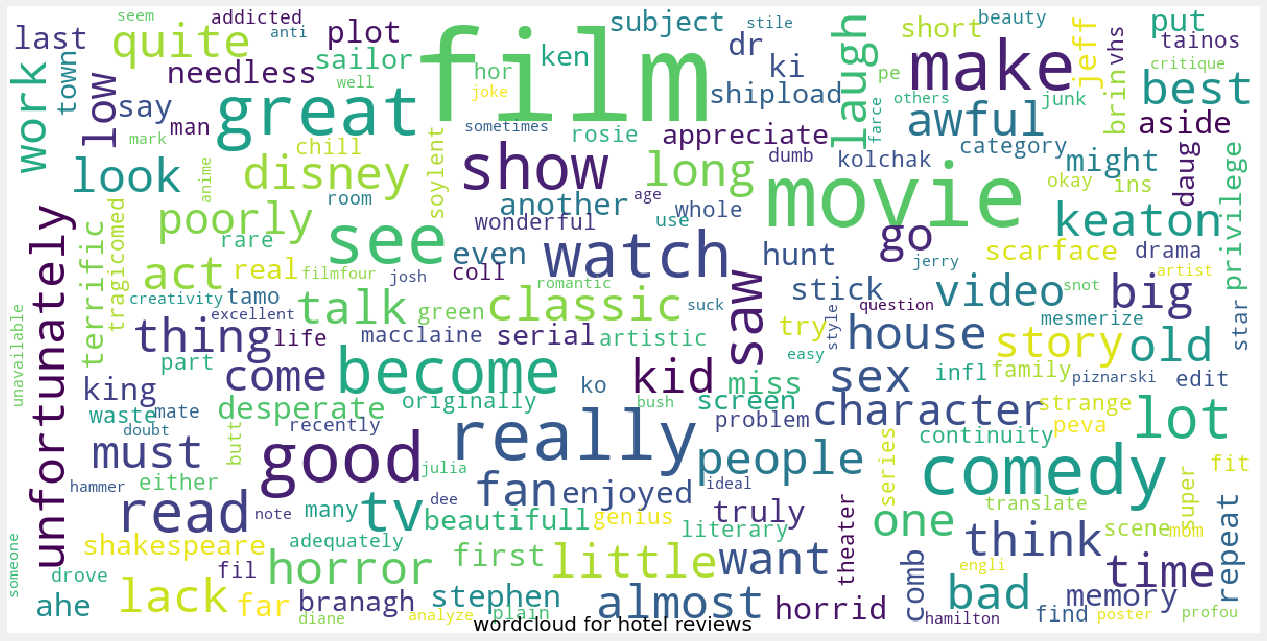

In [54]:
def show_wordcloud(data, title = 'wordcloud for hotel reviews'):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data["SentimentText"])

build model

In [60]:
SEED = 45
x_train, x_validation, y_train, y_validation = train_test_split(data.SentimentText, data.Sentiment, test_size=.2, random_state=SEED)

In [66]:
names = ["KNN","Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    ]
zipped_clf = zip(names,classifiers)

In [67]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 3), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator()

Validation result for KNN
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Average precision-recall score: 0.69
accuracy score: 73.32%
--------------------------------------------------------------------------------
Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average precision-recall score: 0.84
accuracy score: 88.48%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.84
accuracy score: 87.90%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                        

Visualize results of models

In [ ]:
data[data.Sentiment == 0].count()
'''data is balanced'''

In [73]:
'''comparing accuracies of models'''
acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)
data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [75]:
'''comparing ROC curves of models'''
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Then I try to ensemble classifier of the top four accurate models, and see if there is any improvement

In [79]:
clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()


_fp_ = []
_tp_ = []
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Ensemble']
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], names):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    _fp_.append(fp)
    _tp_.append(tp)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average precision-recall score: 0.84
accuracy score: 88.80%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.85
accuracy score: 89.46%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.84
accuracy score: 88.30%
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', to

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average precision-recall score: 0.86
accuracy score: 89.56%
--------------------------------------------------------------------------------


In [80]:
data = []
for i in range(0, len(_fp_)):
    trace = go.Scatter(x=_fp_[i], y=_tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)

grid search and feature selection for logistic regression

In [91]:
vec.fit(x_train)
x_train_t = vec.transform(x_train)
lr = LogisticRegression()
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']
param_grid = {'C': Cs, 'penalty' : penalty}
search = GridSearchCV(lr, param_grid)
search.fit(x_train_t, y_train)
search.best_params_

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



{'C': 10, 'penalty': 'l2'}

In [ ]:
lr2 = LogisticRegression(C=10, penalty='l2')
lr2.fit(x_train_t, y_train)

print("Training acc:", lr.score(x_train_t, y_train), "\nValidation acc:", 
      lr2.score(x_test_t, y_validation))

Backward Stepwise Selection to Reduce Features

Overfitting mainly occurs if the model is too expressive for the given task. As a result, it is able to not only fit the pattern in the training data, but also the randomness of the dataset, which thereby causes a high accuracy on the training data and a low accuracy on the test data. One way to reduce the expressiveness of the model is by reducing the number of features. Currently, we used the count of every word present as a feature, but perhaps some words are more indicative of the sentiment of the review than others. Those other words, which don’t contribute much to determining the sentiment, may be overfitting to the noise in the training set. One way to identify these features is to look at the features whose weights are close to 0 (remember to normalize the weights if using this method). This process is called Backward Stepwise Selection, which aims to remove the features whose removal would reduce the test error.

Feature Selection/Reduction

In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

I selected features here using a recursive feature elimination model that reduces overfitting by shrinking the hypothesis space of our logistic regression model. This didn't give results that were significantly better at reducing overfitting than the L1 regularization above as the testin accuracy increased from 88.5% to a 89.2%, which, when dealing with data at scale, is an increase worth running the backward steps selection (or feature reduction) method.

In [96]:
lr2 = LogisticRegression(C=10, penalty='l2')
lr2.fit(x_train_t, y_train)

vec.fit(x_validation)
x_test_t = vec.transform(x_validation)

print("Training acc:", lr2.score(x_train_t, y_train), "\nValidation acc:", 
      lr2.score(x_test_t, y_validation))


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Training acc: 0.977 
Validation acc: 0.579


In [ ]:
t1 = x_train_t.toarray()
t2 = pd.DataFrame(t1, columns = vec.get_feature_names())
t2.columns = ["word_" + str(x) for x in t2.columns]
t2.index = x_train.index

tt1 = x_test_t.toarray()
tt2 = pd.DataFrame(tt1, columns = vec.get_feature_names())
tt2.columns = ["word_" + str(x) for x in tt2.columns]
tt2.index = x_validation.index



In [129]:
lr2 = LogisticRegression(C=10, penalty='l2')
selector = RFE(lr2, step=10000)
selector.fit(t2, y_train)
lr2 = selector.estimator_
columns = t2.columns
feature_mask = selector.support_
columns_to_drop = [columns[i] for i in range(columns.size) if not feature_mask[i]]
def print_results(estimator, X, y, leadingString=''):
    print(leadingString, estimator.score(X, y))
    
print_results(lr2, t2.drop(columns_to_drop, axis=1), y_train, "Training results: ")
print_results(lr2, tt2.drop(columns_to_drop, axis=1), y_validation, "Testing results: ")

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Training results:  0.9726
Testing results:  0.5736


In [128]:
print('num of features after tfidf vectorization: %s'%(str(tt2.shape)))
print('num of dropped features: %s'%(len(columns_to_drop)))

num of features after tfidf vectorization: (5000, 10000)
num of dropped features: 5000
